In [1]:
import gymnasium as gym
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env

In [2]:
from ipywidgets import IntProgress
from IPython.display import display

In [3]:
from cost_calculator import CostCalculator

In [4]:
dtype = np.int64

In [5]:
M = 10 ** 6

In [6]:
l = 1
n = 5
m = 4
k = 3

In [7]:
T = np.array([
    [  1,   0,   0,   0],
    [0.5, 0.5,   0,   0],
    [  0, 0.5, 0.5,   0],
    [  0,   0, 0.5, 0.5],
    [  0,   0,   0,   1]
])

In [8]:
D = np.array([
    [0, 0, 1, 0],
    [0, 0, 1, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

In [9]:
C = np.array([
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1]
])

In [10]:
E = np.array([
    [1, 0, 0, 0, 0]
])

In [11]:
class CostCalculatorFactory():
    def __init__(self, T, D, C, E):
        self.T = T
        self.D = D
        self.C = C
        self.E = E

    def get_cost_calculator(self, A):
        cost_calculator = CostCalculator(self.T, self.D, self.C, self.E, A)
        return cost_calculator

In [12]:
class CalculateCostStrategy:
    def __init__(self, M, cost_calculator_factory):
        self.M = M
        self.cost_calculator_factory = cost_calculator_factory

    def calculate_cost(self, A):
        cost_calculator = self.cost_calculator_factory.get_cost_calculator(A)
        cost = cost_calculator.calculate()
        
        for row in A:
            if sum(row) != 1:
                cost = self.M
                
        return cost

In [13]:
class MultiBinaryConverter:
    def __init__(self, m, k):
        self.m = m
        self.k = k

    def convert(self, array):
        A = array.reshape(self.m, self.k)
        return A

In [14]:
class MultiDiscreteConverter:
    def __init__(self, m, k):
        self.m = m
        self.k = k
    
    def convert(self, array):
        A = np.zeros((self.m, self.k))
        for i in range(m):
            active_gen = array[i]
            A[i][active_gen] = 1
        return A

In [15]:
class MultiBinaryOperator:
    def __init__(self, m, k, calculate_cost_strategy, converter, dtype):
        self.m = m
        self.k = k
        self.calculate_cost_strategy = calculate_cost_strategy
        self.converter = converter
        self.dtype = dtype
        
        self.count = m * k
        self.action_space = MultiBinary(self.count)
        self.observation_space = Box(low=0, high=1, shape=(self.count, ), dtype=dtype)

    def calculate_cost(self, array):
        A = self.converter.convert(array)
        reward = self.calculate_cost_strategy.calculate_cost(A)
        return reward

In [16]:
class MultiDiscreteOperator:
    def __init__(self, m, k, calculate_cost_strategy, converter, dtype):
        self.m = m
        self.k = k
        self.calculate_cost_strategy = calculate_cost_strategy
        self.converter = converter
        self.dtype = dtype

        self.count = m
        self.action_space = MultiDiscrete([k for i in range(m)])
        self.observation_space = Box(low=0, high=k, shape=(m, ), dtype=self.dtype)

    def calculate_cost(self, array):
        A = self.converter.convert(array)
        reward = self.calculate_cost_strategy.calculate_cost(A)
        return reward

In [17]:
class Graphic:
    def __init__(self, M):
        self.M = M
        self.values = []

    def append_value(self, value):
        self.values.append(value)

    def show(self):
        d = {}
        for value in self.values:
            value = float(value)
            if value in d:
                d[value] += 1
            else:
                d[value] = 0
        keys = []
        values = []
        for key in d:
            keys.append(key)
            values.append(d[key])
        fig, ax = plt.subplots()
        ax.pie(values, labels=keys)
        ax.axis("equal")

In [18]:
class OptimisationTaskEnv(gym.Env):
    def __init__(self, operator, progress, graphic):
        super(OptimisationTaskEnv, self).__init__()
        self.operator = operator
        self.progress = progress
        self.graphic = graphic
        self.dtype = operator.dtype
        self.action_space = operator.action_space
        self.observation_space = operator.observation_space
        self.default_observation = np.zeros(operator.count, dtype=self.dtype)
        self.observation = self.default_observation
        self.info = {}

    def init_observation(self):
        self.observation = np.zeros(self.count, dtype=self.dtype)

    def step(self, action):
        self.observation = np.array(action).astype(self.dtype)

        cost = self.operator.calculate_cost(self.observation)
        self.graphic.append_value(cost)
        reward = 1 / cost

        # cost = (sum(self.observation))
        # print(self.observation)
        # self.graphic.append_value(cost)
        # reward = cost
        

        truncated = False
        terminated = False

        self.progress.value += 1
        return self.observation, float(reward), terminated, truncated, self.info
    
    def reset(self, seed=None, options=None):
        self.observation = self.default_observation
        return (self.observation, self.info)

In [19]:
def learn(env, progress):
    check_env(env)
    # policies: MlpPolicy
    # algorithms: A2C, PPO
    model = A2C("MlpPolicy", env)
    display(progress)
    model.learn(total_timesteps=progress.max)
    observation = model.env.envs[0].env.observation
    return observation

In [20]:
total_timesteps = 1000

In [21]:
cost_calculator_factory = CostCalculatorFactory(T, D, C, E)

In [22]:
calculate_cost_strategy = CalculateCostStrategy(M, cost_calculator_factory)

In [23]:
multibinary_converter = MultiBinaryConverter(m, k)

In [24]:
multidiscrete_converter = MultiDiscreteConverter(m, k)

In [25]:
multibinary_operator = MultiBinaryOperator(m, k, calculate_cost_strategy, multibinary_converter, dtype)

In [26]:
multidiscrete_operator = MultiDiscreteOperator(m, k, calculate_cost_strategy, multidiscrete_converter, dtype)

In [27]:
multibinary_progress = IntProgress(min=0, max=total_timesteps, value=0, description='multibinary', bar_style='success')
multibinary_graphic = Graphic(M)
multibinary_optimisation_task_env = OptimisationTaskEnv(multibinary_operator, multibinary_progress, multibinary_graphic)

In [28]:
multidiscrete_progress = IntProgress(min=0, max=total_timesteps, value=0, description='multidiscrete', bar_style='success')
multidiscrete_graphic = Graphic(M)
multidiscrete_optimisation_task_env = OptimisationTaskEnv(multidiscrete_operator, multidiscrete_progress, multidiscrete_graphic)

IntProgress(value=11, bar_style='success', description='multibinary', max=1000)

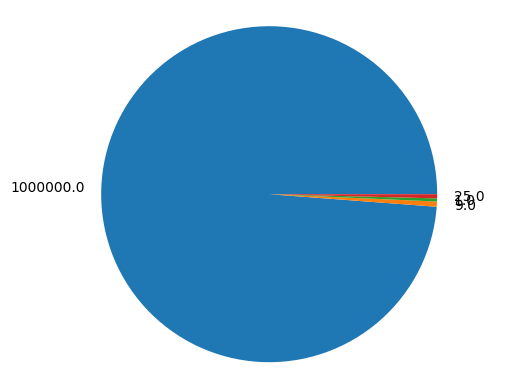

In [29]:
multibinary_result = learn(multibinary_optimisation_task_env, multibinary_progress)
# multibinary_result = multibinary_converter.convert(multibinary_result)
multibinary_result = multibinary_operator.calculate_cost(multibinary_result)
multibinary_graphic.show()

IntProgress(value=11, bar_style='success', description='multidiscrete', max=1000)

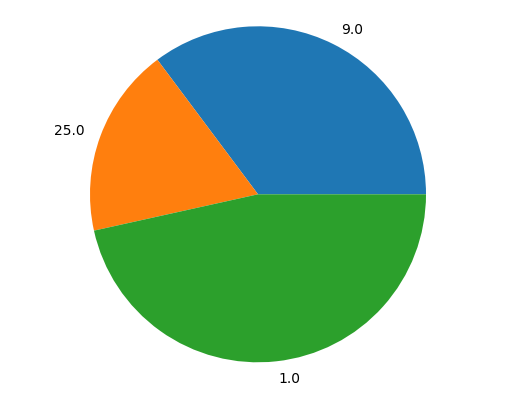

In [30]:
multidiscrete_result = learn(multidiscrete_optimisation_task_env, multidiscrete_progress)
# multidiscrete_result = multidiscrete_converter.convert(multidiscrete_result)
multidiscrete_result = multidiscrete_operator.calculate_cost(multidiscrete_result)
multidiscrete_graphic.show()